<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate detection of adversarial samples using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate the detection of adversarial samples using ART. Our classifier will be a **ResNet** architecture for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image data set.


## Contents

1.	[Loading prereqs and data](#prereqs)
2.  [Evaluating the classifier](#classifier)
3.  [Training the detector](#train_detector)
4.  [Evaluating the detector](#detector)
5.  [Crazy stuff](#crazy)

<a id="prereqs"></a>
## 1. Loading prereqs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod
from art.detection import BinaryInputDetector

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


Load the CIFAR10 data set and class descriptions:

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

n_train = 200
n_test = 200
n_jobs = 4
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<a id="classifier"></a>
## 2. Evaluating the classifier

Load the pre-trained classifier (a ResNet architecture):

In [3]:
path = get_file('cifar_resnet.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_resnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

In [4]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Evaluate the classifier on the first n_test test images:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:n_test]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:n_test], axis=1))

print("Original test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_pred))

Original test data (first n_test images):
Correctly classified: 191
Incorrectly classified: 9


For illustration purposes, look at the first 9 images. (In brackets: true labels.)

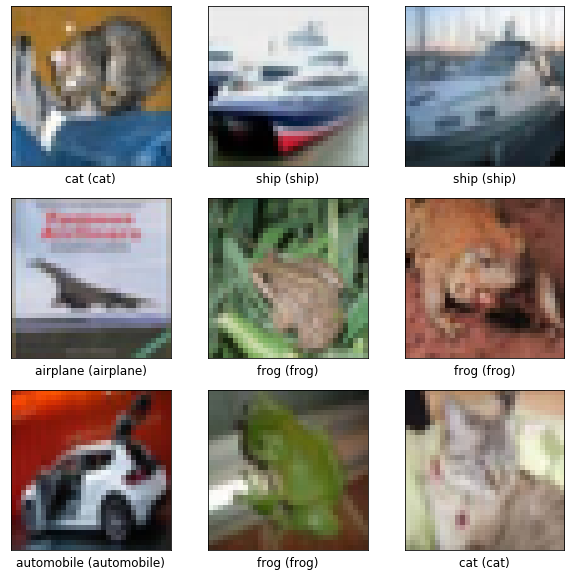

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

Generate some adversarial samples:

In [7]:
attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:n_test]) # this takes about two minutes

Evaluate the classifier on n_test adversarial samples:

In [8]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:n_test], axis=1))

print("Adversarial test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_adv_pred))

Adversarial test data (first n_test images):
Correctly classified: 44
Incorrectly classified: 156


Now plot the adversarial images and their predicted labels (in brackets: true labels).

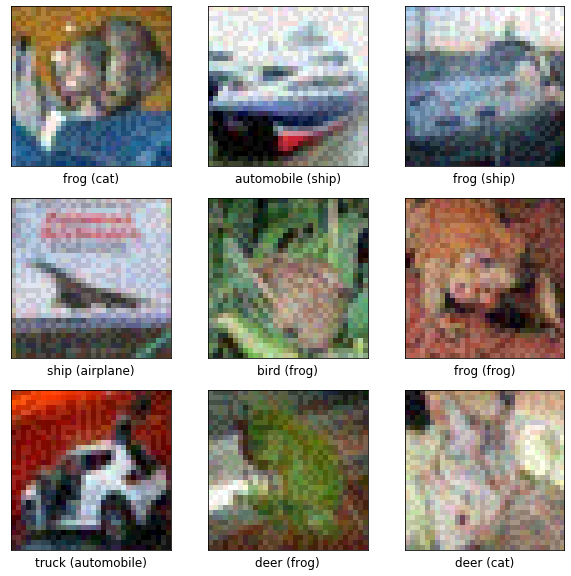

In [9]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

<a id="train_detector"></a>
## 3. Training the detector

Load the detector model (which also uses a ResNet architecture):

In [10]:
path = get_file('BID_eps=0.05.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')
detector_model = load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [11]:
detector_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

To train the detector:
- we expand our training set with adversarial samples
- we label the data with 0 (original) and 1 (adversarial)

In [12]:
x_train_adv = attacker.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

Perform the training:

In [13]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=20)

Epoch 1/20
20/20 [==============================] - 15s 768ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 7s 372ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 8s 405ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 9s 433ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 9s 450ms/step - loss: 0.0829 - accuracy: 0.9875
Epoch 6/20
20/20 [==============================] - 11s 534ms/step - loss: 0.0138 - accuracy: 0.9975
Epoch 7/20
20/20 [==============================] - 10s 484ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 8/20
20/20 [==============================] - 10s 525ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 9/20
20/20 [==============================] - 9s 441ms/step - loss: 0.0255 - accuracy: 0.9975
Epoch 10/20
20/20 [==============================] - 9s 444ms/step - loss: 0.0094 - accuracy: 0.

<a id="detector"></a>
## 4. Evaluating the detector

Apply the detector to the adversarial test data:

In [14]:
flag_adv = np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)

print("Adversarial test data (first n_test images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(n_test - flag_adv))

Adversarial test data (first n_test images):
Flagged: 200
Not flagged: 0


Apply the detector to the first n_test original test images:

In [15]:
flag_original = np.sum(np.argmax(detector.predict(x_test[:n_test]), axis=1) == 1)

print("Original test data (first n_test images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(n_test - flag_original))

Original test data (first n_test images):
Flagged: 200
Not flagged: 0


Evaluate the detector for different attack strengths `eps`
(**Note**: for the training of detector, `eps=0.05` was used)

In [16]:
eps_range = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []
all_x_test_adv = {}

for eps in eps_range:
    if eps > 0:
        attacker.set_params(**{'eps': eps})
        x_test_adv = attacker.generate(x_test[:n_test])
    else:
        x_test_adv = x_test
    all_x_test_adv[eps] = x_test_adv
    nb_flag_adv += [np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:n_test],
                                                                                           axis=1))]
    
eps_range = eps_range
nb_flag_adv = nb_flag_adv
nb_missclass = nb_missclass

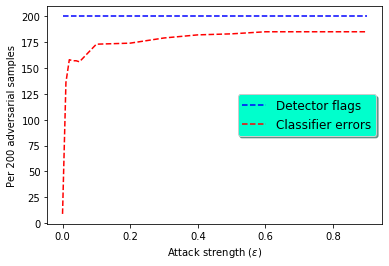

In [17]:
fig, ax = plt.subplots()
ax.plot(eps_range, nb_flag_adv, 'b--', label='Detector flags')
ax.plot(eps_range, nb_missclass, 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Per %d adversarial samples' % n_test)
plt.show()

<a id="crazy"></a>
## 5. Crazy stuff

Now let's build a detector which simply looks at the intermediate activations of the host model. The feature vector of our detector will simply be a concatenation of PCA transforms of these intermediate activations. The detector can run in both `supervised` and `unsupervised` modes, depending on whether `y` is provided or not during fitting. Everything will be done using `sklearn`

In [49]:
import typing

from sklearn.decomposition import PCA
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegressionCV

import keras


class SklearnDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=20, random_state=None, skip_layer_names=None):
        super(SklearnDetector, self).__init__()
        self.n_components = n_components
        self.random_state = random_state
        self.skip_layer_names = skip_layer_names
        
    def _skip_layer(self, layer):
        """
        Decides where layer should be included or excluded in analysis
        """
        bad_names = self.skip_layer_names
        if bad_names is None:
            bad_names = ["input", "flatten", "add", "batch_norm", "dropout", "add", "activation",
                         "classifier", "reshape", "concat"]
        layer_name = layer.name.lower()
        for bad_name in  bad_names:
            if bad_name in layer_name:
                return True
        else:
            return False

    def _get_classifier_output_tensors(self):
        layer_names = []
        outputs = []
        for layer in classifier_model.layers:
            if not self._skip_layer(layer):
                layer_names.append(layer.name)
                outputs.append(layer.output)
        self.layer_names = layer_names
        return outputs
        
    def _build_classifier_activation_model(self):
        """
        Build model for producing intermediate activations of the host classifier.
        """
        outputs = self._get_classifier_output_tensors()
        self.n_layers = len(outputs)
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)

    def _build_layer_pcas(self):
        """
        Build pca model for each intermediate activation layer of host classifier.
        """
        self.pcas = [PCA(n_components=self.n_components, random_state=self.random_state)
                     for _ in self.classifier_activation_model.outputs]

    def _build(self):
        self._build_classifier_activation_model()
        self._build_layer_pcas()

    def _get_classifier_activations(self, X, ravel=True) -> typing.List[np.array]:
        """
        Get the activation of each intermediate layer of the host classifier.
        """
        classifier_activations = self.classifier_activation_model.predict(X)
        if self.n_layers == 1:
            classifier_activations = [classifier_activations]
        if ravel:
            classifier_activations = [Z.reshape((len(Z), -1)) for Z in classifier_activations]
        return classifier_activations
    
    def _transform(self, classifier_activations, concatenate=True):
        codes = [classifier_layer_pca.transform(Z)
                 for classifier_layer_pca, Z in zip(self.pcas, classifier_activations)]
        if concatenate:
            codes = np.concatenate(codes, axis=1)
        return codes
    
    def transform(self, X, concatenate=True):
        """
        Get dimensionality-reduced intermediate activations of host classifier.
        """
        classifier_activations = self._get_classifier_activations(X)
        return self._transform(classifier_activations, concatenate=concatenate)
    
    def fit(self, X, y=None):
        """
        y: ndarray, optional (default None)
            If provided, we will, the detector will be a logistic-regression model (i.e supervised).
            Otherwise, the detector will be a one-class SVM (i.e unsupervided).
        """
        self._build()
        classifier_activations = self._get_classifier_activations(X)
        for classifier_layer_pca, Z in zip(self.pcas, classifier_activations):
            classifier_layer_pca.fit(Z)
        codes = self._transform(classifier_activations)

        if y is None:
            self.final = OneClassSVM()
        else:
            self.final = LogisticRegressionCV(cv=5, random_state=self.random_state)
        self.final.fit(codes, y)
        return self
    
    def predict(self, X):
        codes = self.transform(X)
        return self.final.predict(codes)
    

class SklearnDetectorLastHiddenLayer(SklearnDetector):
    def _build_classifier_activation_model(self):
        outputs = self._get_classifier_output_tensors()
        self.n_layers = 1
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs[-1:])
        
class SklearnDetectorFirstHiddenLayer(SklearnDetector):
    def _build_classifier_activation_model(self):
        outputs = self._get_classifier_output_tensors()
        self.n_layers = 1
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs[:1])

In [81]:
# fit our detectors
n_components = 10
y_detector_flat = 2 * y_train_detector.argmax(1) - 1
my_detectors = {}
my_detectors["supervised"] = SklearnDetector(n_components=n_components).fit(x_train_detector, y_detector_flat)
my_detectors["unsupervised"] = SklearnDetector(n_components=n_components).fit(x_train)
my_detectors["supervised_fhl"] = SklearnDetectorFirstHiddenLayer(
    n_components=2 * n_components).fit(x_train_detector,  y_detector_flat)
my_detectors["unsupervised_fhl"] = SklearnDetectorFirstHiddenLayer(n_components=2 * n_components).fit(x_train)
my_detectors["supervised_lhl"] = SklearnDetectorLastHiddenLayer(
    n_components=2 * n_components).fit(x_train_detector,  y_detector_flat)
my_detectors["unsupervised_lhl"] = SklearnDetectorLastHiddenLayer(n_components=2 * n_components).fit(x_train)

In [82]:
# evaluate the detectors
scores = {}
for which, my_detector in my_detectors.items():
    print("Scores for %s detector" % which)
    y_true = 1
    if "unsupervised" in which:
        y_true = -1
    scores[which] = []
    for eps in all_x_test_adv:
        y_pred = my_detector.predict(all_x_test_adv[eps])
        score = (y_pred == y_true).sum()
        print("%.2f ==> %d" % (eps, score))  
        if which not in scores:
            scores[which] = []
        scores[which].append(score)

Scores for supervised detector
0.00 ==> 6
0.01 ==> 6
0.02 ==> 31
0.03 ==> 130
0.04 ==> 193
0.05 ==> 199
0.10 ==> 200
0.20 ==> 200
0.30 ==> 200
0.40 ==> 200
0.50 ==> 200
0.60 ==> 200
0.70 ==> 200
0.80 ==> 200
0.90 ==> 200
Scores for unsupervised detector
0.00 ==> 30
0.01 ==> 23
0.02 ==> 22
0.03 ==> 19
0.04 ==> 16
0.05 ==> 16
0.10 ==> 161
0.20 ==> 200
0.30 ==> 200
0.40 ==> 200
0.50 ==> 200
0.60 ==> 200
0.70 ==> 200
0.80 ==> 200
0.90 ==> 200
Scores for supervised_fhl detector
0.00 ==> 110
0.01 ==> 110
0.02 ==> 110
0.03 ==> 110
0.04 ==> 109
0.05 ==> 110
0.10 ==> 114
0.20 ==> 115
0.30 ==> 115
0.40 ==> 126
0.50 ==> 129
0.60 ==> 137
0.70 ==> 146
0.80 ==> 151
0.90 ==> 151
Scores for unsupervised_fhl detector
0.00 ==> 72
0.01 ==> 72
0.02 ==> 71
0.03 ==> 70
0.04 ==> 70
0.05 ==> 70
0.10 ==> 62
0.20 ==> 49
0.30 ==> 30
0.40 ==> 14
0.50 ==> 4
0.60 ==> 1
0.70 ==> 0
0.80 ==> 0
0.90 ==> 0
Scores for supervised_lhl detector
0.00 ==> 9
0.01 ==> 24
0.02 ==> 46
0.03 ==> 106
0.04 ==> 151
0.05 ==> 183
0.10 =

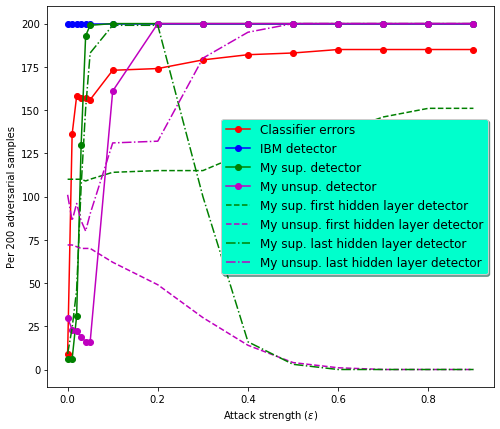

In [83]:
# plot the results
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(eps_range, nb_missclass, 'r-o', label='Classifier errors')
ax.plot(eps_range, nb_flag_adv, 'b-o', label='IBM detector')
ax.plot(eps_range, scores["supervised"], 'g-o', label='My sup. detector')
ax.plot(eps_range, scores["unsupervised"], 'm-o', label='My unsup. detector')
ax.plot(eps_range, scores["supervised_fhl"], 'g--', label='My sup. first hidden layer detector')
ax.plot(eps_range, scores["unsupervised_fhl"], 'm--', label='My unsup. first hidden layer detector')
ax.plot(eps_range, scores["supervised_lhl"], 'g-.', label='My sup. last hidden layer detector')
ax.plot(eps_range, scores["unsupervised_lhl"], 'm-.', label='My unsup. last hidden layer detector')

legend = ax.legend(loc='best', shadow=True, fontsize="large")
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Per %d adversarial samples' % n_test)
plt.show()

We see that:

- IBM's detector solves the task perfectly. However, it will presumably be less accurate on attacks generated via another method
- Our supervised detector solves the task!
- Neither the first hidden layer nor the last hidden layer is solely sufficient for detecting adversarial examples. We need all intermediate layer activations to solve the task!

In [84]:
# compute the hidden representations used by our detectors
all_codes = []
which = "unsupervised"
for X in all_x_test_adv.values():
    codes = my_detectors[which].transform(X)
    all_codes.append(codes)
all_codes = np.concatenate(all_codes, axis=0)

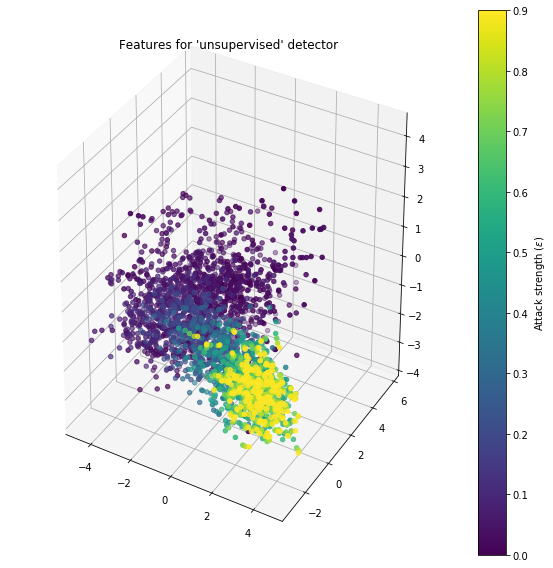

In [100]:
# visualize the hidden representations
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from sklearn.manifold import TSNE

colors = np.concatenate([np.full(len(all_x_test_adv[eps]), eps) for eps in all_x_test_adv])
if False:
    visu = TSNE(n_components=3).fit_transform(all_codes)
else:
    visu = all_codes[:, -10:-7]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(*visu.T, c=colors)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Attack strength ($\\varepsilon$)");
plt.title("Features for '%s' detector" % which)
plt.tight_layout()